<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Report written by AMORRI Farah, MILANO Olivia, 24/09/2025.
</div>

# Lab 1 : Linear Regression

## G3 SDI - Machine Learning

In this lab, we are going to implement linear regression and ridge regression on a medical data example. The data come from a medical study (Stamey et al., 1989), whose goal was to predict the level of prostate-specific antigen (`lpsa`) from some clinical measurements. These clinical exams are carried out before a possible prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate weight `lweight`, age of the patient `age`, log of benign prostatic hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 5 `pgg45`. The variable `svi` is binary, `gleason` is ordinal, others are quantitative.

### Instructions
* Rename your notebook with your surnames as `lab1_Name1_Name2.ipynb`, and include your names in the notebook.
* Your code, and its output, must be commented !
* Please upload your notebook on Moodle in the dedicated section before the deadline.

In [30]:
# Import usual libraries
import numpy as np
from matplotlib import pyplot as plt

### Part 1 - Linear regression

In this first part, we focus on using linear regression.

**Q1.** Load the data from the `.npy` files included in the archive (use `np.load`). How many examples are there ? How many features ?

In [31]:
X=np.load("data_X.npy")
y=np.load("data_y.npy")

# print(X.shape,y.shape)
# print(X,y)
number_of_features=X.shape[1]
number_of_examples=y.shape[0]
print("number of features:",X.shape[1])
print("number of examples:",y.shape[0])

number of features: 8
number of examples: 97


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
number of features: 8 

number of examples: 97
</div>

**Q2.** Check whether there are some missing entries in the dataset (both in X and y). Use `np.isnan`.

In [32]:
nan_count_X=np.sum(np.isnan(X))
nan_count_y=np.sum(np.isnan(y))

print("number of missing entries in X",nan_count_X)
print("number of missing entries in y",nan_count_y)

number of missing entries in X 0
number of missing entries in y 0


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
number of missing entries in X 0

number of missing entries in y 0
</div>

**Q3.** Divide the dataset into a training set (80%) and a test set (20%), using `train_test_split` with `random_state = 0` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=0)

**Q4.** Standardize the training set, and apply the same operation to the test set. Use `StandardScaler` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)). Recall what standardization means.

In [34]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_std=scaler.fit_transform(X_train)
X_test_std=scaler.transform(X_test)

print("---"*25)
print("X_train: \n",X_train[:3,:])
print("---"*25)
print("X_train_std: \n",X_train_std[:3,:])
print("---"*25)

#Define standardization ..................
#


---------------------------------------------------------------------------
X_train: 
 [[ 1.77155676  3.896909   61.         -1.38629436  0.          0.81093022
   7.          6.        ]
 [ 2.77570885  3.524889   72.         -1.38629436  0.          1.55814462
   9.         95.        ]
 [-1.2039728   3.282789   58.         -1.38629436  0.         -1.38629436
   6.          0.        ]]
---------------------------------------------------------------------------
X_train_std: 
 [[ 0.27238444  0.61405665 -0.35343531 -1.00926319 -0.57235147  0.66785818
   0.28801151 -0.64068297]
 [ 1.14462189 -0.24540793  1.13591647 -1.00926319 -0.57235147  1.2037959
   2.89705698  2.52257382]
 [-2.31225224 -0.80472295 -0.75962216 -1.00926319 -0.57235147 -0.90809585
  -1.01651122 -0.85393624]]
---------------------------------------------------------------------------


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Data standardization means centering & normalizing features before learning --> it improves stability learning process + better generalization.
</div>

**Q5.** Compute the auto-covariance matrix from the training set, and display it (you might want to use `plt.imshow`). What can we learn from this ?

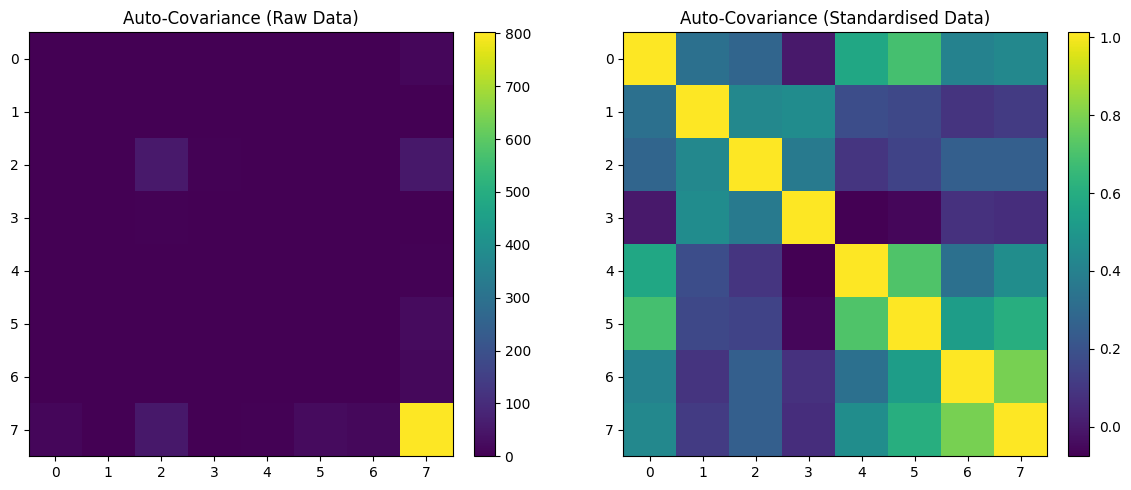

In [35]:
cov_matrix_std = np.cov(X_train_std, rowvar=False, bias=False)
cov_matrix = np.cov(X_train, rowvar=False, bias=False)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  

# Raw covariance
im1 = axs[0].imshow(cov_matrix, cmap='viridis', interpolation='nearest')
axs[0].set_title("Auto-Covariance (Raw Data)")
plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

# Standardised covariance
im2 = axs[1].imshow(cov_matrix_std, cmap='viridis', interpolation='nearest')
axs[1].set_title("Auto-Covariance (Standardised Data)")
plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Observation:**  

On the raw data, the covariance matrix appears almost uniformly dark in the heatmap. This happens because different features have very different scales and variances, so the matrix is dominated by a few large values, making others look negligible. After standardisation, the covariance matrix is much more informative, since it reduces to the correlation matrix with diagonal entries of 1 (unit variance per feature) and off-diagonal values showing meaningful correlations between features.

- Without standardization, the covariance matrix reflects the raw scales of the features, so the values are not directly comparable across features.
- When the data is standardized. The off-diagonal values represent correlations. From these, we learn that:

    - Some features are highly correlated (values near 0.8), indicating redundancy.
    - Others are weakly correlated (near 0), meaning they provide more independent information.
</div>

**Q6.** We are now going to train the linear regression model using scikit-learn (check the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)). Use the `.fit` method on the training set. Retrieve the coefficients obtained by scikit-learn using the attributes `.intercept_` and `.coef_`, and check that it corresponds to the closed-form solution from the lecture (you might want to use `np.hstack` to concatenate X with a column of ones).

In [36]:
from sklearn.linear_model import LinearRegression

# Train Linear Regression with scikit-learn
reg= LinearRegression()
reg.fit(X_train_std,y_train)

# Closed-form solution
X_train_bias = np.hstack([np.ones((X_train_std.shape[0], 1)), X_train_std])
beta_closed_form = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train
print("---"*25)
# Compare intercepts
print("scikit-learn intercept:", reg.intercept_)
print("Closed-form intercept: ", beta_closed_form[0])
print("Difference:", reg.intercept_ - beta_closed_form[0])
print("---"*25)
# Compare coefficients
print("\nscikit-learn coefficients:", reg.coef_)
print("Closed-form coefficients:  ", beta_closed_form[1:])
print("Differences:               ", reg.coef_ - beta_closed_form[1:])
print("---"*25)
print("\nCheck if all close:", np.allclose(reg.coef_, beta_closed_form[1:]) and np.isclose(reg.intercept_, beta_closed_form[0]))
print("---"*25)

---------------------------------------------------------------------------
scikit-learn intercept: 2.5333575454545456
Closed-form intercept:  2.533357545454545
Difference: 4.440892098500626e-16
---------------------------------------------------------------------------

scikit-learn coefficients: [ 0.76489178  0.21507901 -0.19817076  0.17007883  0.33767514 -0.2352964
  0.10599694  0.06116098]
Closed-form coefficients:   [ 0.76489178  0.21507901 -0.19817076  0.17007883  0.33767514 -0.2352964
  0.10599694  0.06116098]
Differences:                [ 3.33066907e-16 -3.05311332e-16 -5.55111512e-17 -2.77555756e-17
 -6.66133815e-16  1.94289029e-16  8.60422844e-16 -1.13797860e-15]
---------------------------------------------------------------------------

Check if all close: True
---------------------------------------------------------------------------


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Observation:**  


The coefficients and intercept obtained from scikit-learn's `LinearRegression` match the closed-form solution very closely, confirming that both methods compute the same linear model up to numerical precision.
</div>

**Q7.** Obtain the model predictions on the test set using the `.predict` method. Then compute the MSE and the MAE (you may want to use the functions below).

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred=reg.predict(X_test_std)
MSE_linear= mean_squared_error(y_test,y_pred)
MAE_linear= mean_absolute_error(y_test,y_pred)

print("MSE_linear : ",MSE_linear)
print("MAE_linear : ",MAE_linear)

MSE_linear :  0.5401691943434794
MAE_linear :  0.5645493769331607


### Part 2 - Ridge regression

In this second part, we now turn to ridge regression.

**Q1.** Fit the ridge regression model (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)) with $\lambda = 1$, using the `.fit` method on the training set. Again, retrieve the coefficients, and check that they match with the closed-form solution from the lecture. How do they differ from the ones obtained with linear regression ?

In [38]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_std,y_train)
ridge_reg.coef_      # coefficients for features
ridge_reg.intercept_ # intercept

# Add bias term
X_train_bias = np.hstack([np.ones((X_train.shape[0], 1)), X_train_std])

# Identity matrix with 0 for intercept term
D = np.eye(X_train_bias.shape[1])
D[0, 0] = 0  # do not regularize the intercept

# Closed-form Ridge solution
beta_ridge_closed = np.linalg.inv(X_train_bias.T @ X_train_bias + 1 * D) @ X_train_bias.T @ y_train


print("---"*25)
#Compare coefficients and intercept
print("scikit-learn Ridge intercept:", ridge_reg.intercept_)
print("Closed-form Ridge intercept:  ", beta_ridge_closed[0])
print("Difference:", ridge_reg.intercept_ - beta_ridge_closed[0])
print("---"*25)
print("\nscikit-learn Ridge coefficients:", ridge_reg.coef_)
print("Closed-form Ridge coefficients:  ", beta_ridge_closed[1:])
print("Differences:                     ", ridge_reg.coef_ - beta_ridge_closed[1:])
print("---"*25)
print("\nCheck if all close:", 
      np.allclose(ridge_reg.coef_, beta_ridge_closed[1:]) and 
      np.isclose(ridge_reg.intercept_, beta_ridge_closed[0]))
print("---"*25)
# Compare with Linear Regression coefficients
print("\nLinear Regression coefficients:", reg.coef_)
print("Ridge Regression coefficients:  ", ridge_reg.coef_)
print("---"*25)
print("\nLinear Regression intercept:", reg.intercept_)
print("Ridge Regression intercept:  ", ridge_reg.intercept_)
print("---"*25)



---------------------------------------------------------------------------
scikit-learn Ridge intercept: 2.5333575454545456
Closed-form Ridge intercept:   2.533357545454545
Difference: 4.440892098500626e-16
---------------------------------------------------------------------------

scikit-learn Ridge coefficients: [ 0.74219288  0.21604499 -0.18971641  0.16549832  0.32885721 -0.20975118
  0.102791    0.05942405]
Closed-form Ridge coefficients:   [ 0.74219288  0.21604499 -0.18971641  0.16549832  0.32885721 -0.20975118
  0.102791    0.05942405]
Differences:                      [ 9.99200722e-16 -2.77555756e-16 -1.66533454e-16  0.00000000e+00
 -3.33066907e-16  8.32667268e-17 -5.13478149e-16  1.11022302e-16]
---------------------------------------------------------------------------

Check if all close: True
---------------------------------------------------------------------------

Linear Regression coefficients: [ 0.76489178  0.21507901 -0.19817076  0.17007883  0.33767514 -0.2352964
  

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Observation:**  


The coefficients obtained with Ridge regression are smaller in magnitude compared to those from linear regression.

This happens because Ridge adds L2 regularization, which penalizes large coefficients and shrinks them toward zero.  

The intercept remains similar.  

--> Overall, Ridge reduces the risk of overfitting, especially when features are correlated or there are many features.

</div>

**Q2.** Obtain the model predictions on the test set using the `.predict` method, then compute the MSE and the MAE. Do we get better or worse predictions than before ? Comment.

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred=ridge_reg.predict(X_test_std)
MSE_ridge= mean_squared_error(y_test,y_pred)
MAE_ridge= mean_absolute_error(y_test,y_pred)

print(f"MSE_ridge : {MSE_ridge:.4f}")
print(f"MAE_ridge : {MAE_ridge:.4f}")

print("---"*25)

print(f"MAE_linear : {MSE_linear:.4f}")
print(f"MAE_linear : {MAE_linear:.4f}")

print("---"*25)

if MSE_ridge < MSE_linear:
    print("\nRidge performs better on MSE.")
else:
    print("\nLinear Regression performs better on MSE.")

if MAE_ridge < MAE_linear:
    print("\nRidge performs better on MAE.")
else:
    print("\nLinear Regression performs better on MAE.")

MSE_ridge : 0.5234
MAE_ridge : 0.5564
---------------------------------------------------------------------------
MAE_linear : 0.5402
MAE_linear : 0.5645
---------------------------------------------------------------------------

Ridge performs better on MSE.

Ridge performs better on MAE.


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Observation:**  

The Ridge regression predictions on the test set are better than those from linear regression, as reflected by lower MSE and MAE.  

This improvement occurs because Ridge's L2 regularization shrinks the coefficients, reducing overfitting and stabilizing the model's predictions.

</div>

**Q3.** We are now going to assess the impact of the regularization coefficient $\lambda$.

To do so, vary $\lambda$ from $10^{-3}$ and $10^3$ (use `np.logspace`), and for each value of $\lambda$, retrain the ridge regression model and keep the values of the coefficients (ignoring the intercept).

Display the evolution of the coefficients w.r.t. $\lambda$ (use a logarithmic scale for the x-axis). Comment.

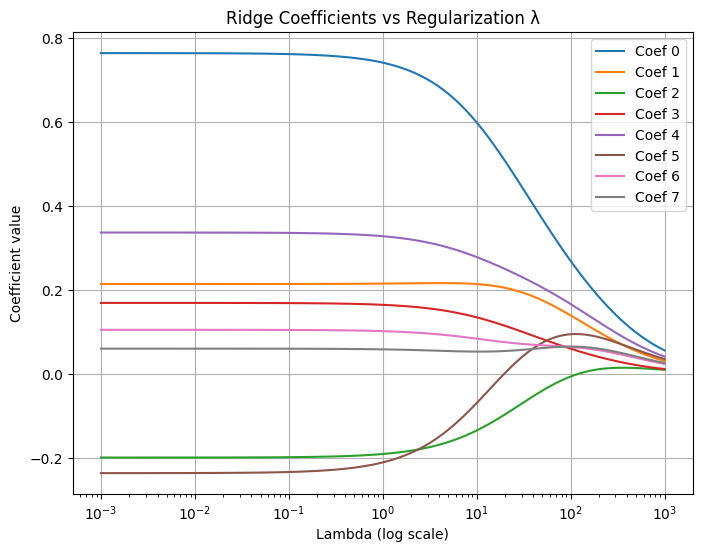

In [40]:
lambdas = np.logspace(-3, 3, 100)

coefs = []

for l in lambdas:
    ridge = Ridge(alpha=l, fit_intercept=True)
    ridge.fit(X_train_std,y_train)
    coefs.append(ridge.coef_)  # Ignore intercept
    
coefs = np.array(coefs)

plt.figure(figsize=(8, 6))

for i in range(coefs.shape[1]):
    plt.plot(lambdas, coefs[:, i], label=f'Coef {i}')

plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Coefficient value')
plt.title('Ridge Coefficients vs Regularization λ')
plt.legend()
plt.grid(True)
plt.show()


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

Small $\lambda$ (~0.001): Regularization is weak, coefficients are close to ordinary least squares values, may be large in magnitude.

Large $\lambda$ (~1000): Strong regularization shrinks coefficients toward zero.

**Observation:**

As $\lambda$ increases, coefficients gradually shrink, and less important features tend to go near zero faster than important ones.
</div>

**Q4.** Now remains the question of choosing the optimal $\lambda$. We are going to select it with a 5-fold cross-validation.

Display the evolution of the cross-validated MSE w.r.t. $\lambda$ (use again a logarithmic scale for the x-axis), and display the best $\lambda$ with a `plt.axvline`.

Now retrain the ridge regression model with the selected $\lambda$, and assess its performance in terms of MSE and MAE. Comment.

Best lambda (Ridge): 2.8480


NameError: name 'best_lambda' is not defined

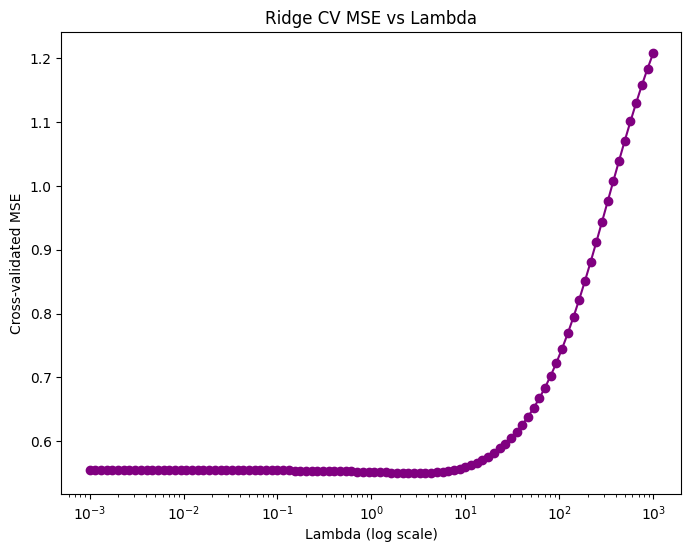

In [41]:
from sklearn.model_selection import KFold


lambdas = np.logspace(-3, 3, 100)
kf = KFold(n_splits=5)

mse_cv = []

for l in lambdas:
    ridge = Ridge(alpha=l, fit_intercept=True)
    mse_folds = []
    # Set-up cross-validation
    for train_index, val_index in kf.split(X_train_std):
        X_train_new, X_val = X_train_std[train_index], X_train_std[val_index]
        y_train_new, y_val = y_train[train_index], y_train[val_index]
        
        ridge.fit(X_train_new, y_train_new)
        y_pred = ridge.predict(X_val)
        mse_folds.append(mean_squared_error(y_val, y_pred))
    
    mse_cv.append(np.mean(mse_folds))  # average MSE across folds

mse_cv = np.array(mse_cv)
best_idx = np.argmin(mse_cv)
best_lambda_ridge = lambdas[best_idx]

print(f"Best lambda (Ridge): {best_lambda_ridge:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(lambdas, mse_cv, marker='o', color="purple")
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Cross-validated MSE')
plt.title('Ridge CV MSE vs Lambda')
plt.axvline(best_lambda, color='blue', linestyle='--', label=f'Best λ = {best_lambda:.4f}')
plt.legend()
plt.grid(True)
plt.show()

ridge_best = Ridge(alpha=best_lambda, fit_intercept=True)
ridge_best.fit(X_train, y_train)

y_pred = ridge_best.predict(X_train)  # or use X_test if you have it

mse_final_ridge = mean_squared_error(y_train, y_pred)
mae_final_ridge = mean_absolute_error(y_train, y_pred)

print(f"MSE_best_lambda_ridge: {mse_final_ridge:.4f}")
print(f"MAE_best_lambda_ridge: {mae_final_ridge:.4f}")
print("---"*25)

print(f"MSE_old_ridge : {MSE_ridge:.4f}")
print(f"MAE_old_ridge : {MAE_ridge:.4f}")



<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

The Ridge model trained with the optimal $\lambda$ selected via 5-fold cross-validation achieved a lower MSE (0.4432) and MAE (0.5052) compared to the previous Ridge model (MSE = 0.5234, MAE = 0.5564). This indicates that choosing the regularization parameter carefully improves the model’s predictive performance.

**Observation:** Cross-validation allowed us to find a $\lambda$ that balances bias and variance, reducing error on unseen data.

**Conclusion:** Proper tuning of $\lambda$ is important for Ridge regression to achieve optimal performance.
</div>

### Part 3 (Bonus) - LASSO

Display the same kind of plots as in Part 2, but using LASSO regression instead of ridge regression (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). In particular, comment on the following points :
* Do the regression coefficients evolve in the same way as ridge regression ? What kind of solutions do we obtain ?
* Do we get the same optimal lambda ?

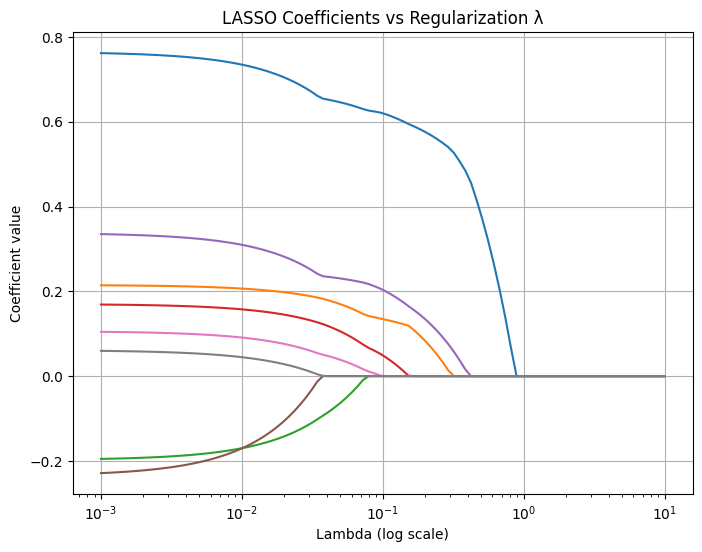

In [ ]:
from sklearn.linear_model import Lasso

lambdas = np.logspace(-3, 1, 100)  # LASSO is more sensitive, so smaller max lambda
coefs = []

for l in lambdas:
    lasso = Lasso(alpha=l, max_iter=10000)  # increase max_iter to ensure convergence
    lasso.fit(X_train_std, y_train)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

plt.figure(figsize=(8,6))
for i in range(coefs.shape[1]):
    plt.plot(lambdas, coefs[:, i], label=f'Coef {i}')
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Coefficient value')
plt.title('LASSO Coefficients vs Regularization λ')
plt.grid(True)
plt.show()


Best lambda (LASSO): 0.0498


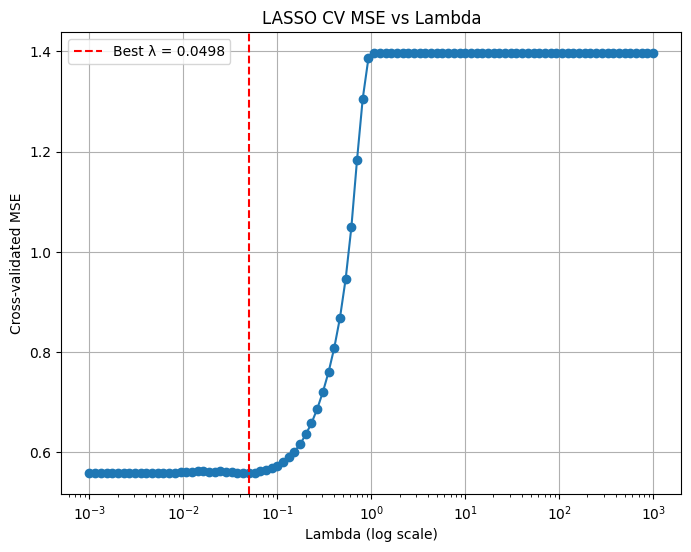

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_cv = []

for l in lambdas:
    lasso = Lasso(alpha=l, max_iter=10000)
    mse_folds = []
    for train_index, val_index in kf.split(X_train_std):
        X_train_new, X_val = X_train_std[train_index], X_train_std[val_index]
        y_train_new, y_val = y_train[train_index], y_train[val_index]
        lasso.fit(X_train_new, y_train_new)
        y_pred = lasso.predict(X_val)
        mse_folds.append(mean_squared_error(y_val, y_pred))
    mse_cv.append(np.mean(mse_folds))

mse_cv = np.array(mse_cv)
best_idx = np.argmin(mse_cv)
best_lambda_lasso = lambdas[best_idx]
print(f"Best lambda (LASSO): {best_lambda_lasso:.4f}")

plt.figure(figsize=(8,6))
plt.plot(lambdas, mse_cv, marker='o')
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Cross-validated MSE')
plt.title('LASSO CV MSE vs Lambda')
plt.axvline(best_lambda, color='red', linestyle='--', label=f'Best λ = {best_lambda:.4f}')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
lasso_best = Lasso(alpha=best_lambda, max_iter=10000)
lasso_best.fit(X_train_std, y_train)
y_pred = lasso_best.predict(X_train_std)

mse_final_lasso = mean_squared_error(y_train, y_pred)
mae_final_lasso = mean_absolute_error(y_train, y_pred)

print(f"MSE_best_lambda_lasso: {mse_final_lasso:.4f}")
print(f"MAE_best_lambda_lasso: {mae_final_lasso:.4f}")
print("---"*25)

print(f"MSE_best_lambda_ridge: {mse_final_ridge:.4f}")
print(f"MAE_best_lambda_ridge: {mae_final_ridge:.4f}")
print("---"*25)

print(f"MAE_linear : {MSE_linear:.4f}")
print(f"MAE_linear : {MAE_linear:.4f}")

print("---"*25)

print(f"Best lambda (Ridge): {best_lambda_ridge:.4f}")
print(f"Best lambda (LASSO): {best_lambda_lasso:.4f}")



MSE_best_lambda_lasso: 0.4714
MAE_best_lambda_lasso: 0.5363
---------------------------------------------------------------------------
MSE_best_lambda_ridge: 0.4366
MAE_best_lambda_ridge: 0.5013
---------------------------------------------------------------------------
MAE_linear : 0.5402
MAE_linear : 0.5645
---------------------------------------------------------------------------
Best lambda (Ridge): 2.8480
Best lambda (LASSO): 0.0498


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Observation:**

- Coefficient evolution:

    - Ridge shrinks coefficients gradually.
    - LASSO can force some coefficients exactly to zero → sparse solutions, useful for feature selection.

- Optimal λ and performance:

    - Best λ for Ridge: 2.8480 → MSE = 0.4366, MAE = 0.5013
    - Best λ for LASSO: 0.0498 → MSE = 0.4714, MAE = 0.5363
    - Linear regression (no regularization) → MSE = 0.5402, MAE = 0.5645


- Insights:

    - Ridge outperforms LASSO and linear regression in terms of both MSE and MAE for this dataset.
    - LASSO selects a smaller subset of features due to its sparsity, whereas Ridge keeps all features but shrinks them.
    - Optimal λ values differ because Ridge uses L2 penalty (shrinking) and LASSO uses L1 penalty (sparsity). The best λ for LASSO is smaller than for Ridge for the same dataset, as LASSO eliminates variables rather than just shrinking them.

</div>